In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys

sys.path.append("../stochman/")

from stochman import nnj

# Define conv parameters

In [13]:
# Set parameters (free to change)

N = 6 #input edge
kernel_size = 3
padding = 0
stride = 1 #don't change me please, bad things will happen
dilation = 1

##############################################################################
#compute input/output shapes

M = ( N - dilation*(kernel_size-1) + 2*padding -1 )/stride +1 #output edge before integer
int_M = int(M)
output_padding = N - ((int_M-1)*stride - 2*padding + dilation*(kernel_size-1) + 1) ##### GOLD LINE ######
int_N = (int_M-1)*stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
print('input size N=',N, int_N, N==int_N)
print('output size M=',M,int_M, M==int_M)

M=int_M #output edge
W = kernel_size

input size N= 6 6 True
output size M= 4.0 4 True


Define convolution layer and its transposed

In [14]:
# Define regular layer
conv = nnj.Conv2d(1,1,kernel_size=kernel_size,padding=padding,stride=stride,dilation=dilation, bias=None)
weights = conv.weight[0,0].detach().numpy()

# Define transposed
conv_transpose = nnj.ConvTranspose2d(1,1,kernel_size=kernel_size,padding=padding,stride=stride,dilation=dilation, output_padding=output_padding, bias=None)
conv_transpose.weight = conv.weight

Set input and generate output

In [15]:
# Define input
tmp = torch.randint(0, 10, (1, N, N)).type(torch.float)
input = tmp.unsqueeze(0).type(torch.float)
# Compute output
output = conv(input)

Define the same convolution and transposed, but with weights as argument

In [16]:
# Define reversed conv (for jac wrt weights)
dw_padding = W - 1 - padding
conv_dw = nnj.ConvTranspose2d(1,1,kernel_size=kernel_size,padding=dw_padding,stride=stride,dilation=dilation, output_padding=0, bias=None)
#   - the new input is the old weight
dw_input = torch.tensor(weights).unsqueeze(0).unsqueeze(0).type(torch.float)
#   - the new weights are the reversed of the old input
reversed_input = torch.zeros_like(input)
for i in range(N):
    for j in range(N):
        reversed_input[0,0,i,j] = input[0,0,N-i-1,N-j-1]
conv_dw.weight = torch.nn.Parameter(reversed_input)

#Define trasposed of reversed conv
conv_dw_transposed = nnj.Conv2d(1,1,kernel_size=kernel_size,padding=dw_padding,stride=stride,dilation=dilation, bias=None)
conv_dw_transposed.weight = torch.nn.Parameter(reversed_input)

Asses that "conv" and "conv_dw" actually encode the same function

Text(0.5, 0.98, 'Conv2d')

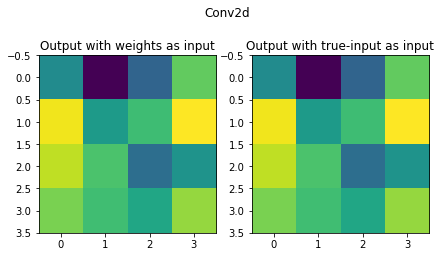

In [17]:
dw_output = conv_dw(dw_input)
reversed_dw_output = torch.zeros_like(dw_output)
for i in range(M):
    for j in range(M):
        reversed_dw_output[0,0,i,j] = dw_output[0,0,M-i-1,M-j-1]

plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.title('Output with weights as input')
plt.imshow(reversed_dw_output[0,0].detach().numpy())
plt.subplot(1,2,2)
plt.title('Output with true-input as input')
plt.imshow(output[0,0].detach().numpy())
plt.suptitle('Conv2d')
#diff = reversed_dw_output[0,0] - output[0,0]
#print(diff)

#plots should be equal

# Jacobian of conv (wrt. input)

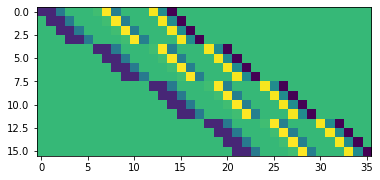

In [18]:
print_each_column_computation = False

# N*N = number of inputs
# M*M = number of ouputs

full_jacobian = torch.zeros(M*M,N*N)
for i in range(N):
    for j in range(N):
        # define base element
        jac_in = torch.zeros(1,1,N,N).type(torch.float)
        jac_in[0,0,i,j] = 1

        # compute a column of full_jacobian by conv(base_element)
        jacobian = conv._jacobian_mult(input, output, jac_in)

        # store the image returned by conv as a column vector
        col = N*i+j
        for k in range(M):
            for q in range(M):
                row = M*k+q
                full_jacobian[row,col] = jacobian[0,0,k,q]

        if print_each_column_computation:
            plt.figure(figsize=(6,3))
            plt.subplot(1,4,1)
            plt.imshow(jac_in[0,0].detach().numpy())
            plt.subplot(1,4,2)
            plt.imshow(jacobian[0,0].detach().numpy())
            plt.show()

plt.imshow(full_jacobian.detach().numpy())

# Jacobian of conv (wrt. input) transposed

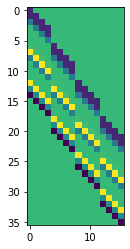

In [19]:
full_jacobianT = torch.zeros(N*N,M*M)
for i in range(M):
    for j in range(M):
        jac_in = torch.zeros(1,1,M,M).type(torch.float)
        jac_in[0,0,i,j] = 1

        #same as before, but with "conv_transpose" and changing output/input
        jacobian = conv_transpose._jacobian_mult(output, input, jac_in)

        col = M*i+j
        for k in range(N):
            for q in range(N):
                row = N*k+q
                full_jacobianT[row,col] = jacobian[0,0,k,q]

        if print_each_column_computation:
            plt.figure(figsize=(6,3))
            plt.subplot(1,4,1)
            plt.imshow(jac_in[0,0].detach().numpy())
            plt.subplot(1,4,2)
            plt.imshow(jacobian[0,0].detach().numpy())
            plt.show()

plt.imshow(full_jacobianT.detach().numpy())

# Jacobian of conv (wrt. weights)

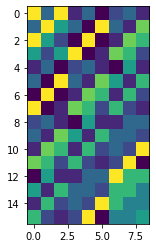

In [20]:
# N*N = number of inputs
# M*M = number of ouputs
# W*W = number of weights

full_jacobian_dw = torch.zeros(M*M,W*W)

for i in range(W):
    for j in range(W):
        jac_in = torch.zeros(1,1,W,W).type(torch.float)
        jac_in[0,0,i,j] = 1

        jacobian = conv_dw._jacobian_mult(dw_input, dw_output, jac_in)
        #reversed_jac = torch.zeros_like(jacobian)
        #for k in range(W):
        #    for q in range(W):
        #        reversed_jac[0,0,k,q] = jacobian[0,0,W-k-1,W-q-1]
        #jacobian = reversed_jac

        #col = W*W - (W*i+j) - 1 #WRONG! DON'T DO I, must flip on rows, not columns
        col = W*i+j
        for k in range(M):
            for q in range(M):
                row = -(M*k+q) - 1 #flip on rows
                full_jacobian_dw[row, col] = jacobian[0,0,k,q]

        if print_each_column_computation:
            plt.figure(figsize=(6,3))
            plt.subplot(1,4,1)
            plt.imshow(jac_in[0,0].detach().numpy())
            plt.subplot(1,4,2)
            plt.imshow(jacobian[0,0].detach().numpy())
            plt.show()

plt.imshow(full_jacobian_dw.detach().numpy())

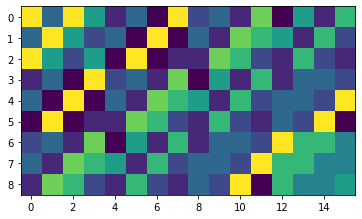

In [21]:
full_jacobian_dw_T = torch.zeros(W*W,M*M)
for i in range(M):
    for j in range(M):
        jac_in = torch.zeros(1,1,M,M).type(torch.float)
        jac_in[0,0,i,j] = 1

        jacobian = conv_dw_transposed._jacobian_mult(dw_output, dw_input, jac_in)

        col = (M*M) - (M*i+j) - 1
        for k in range(W):
            for q in range(W):
                row = W*k+q
                full_jacobian_dw_T[row,col] = jacobian[0,0,k,q]

        if print_each_column_computation:
            plt.figure(figsize=(6,3))
            plt.subplot(1,4,1)
            plt.imshow(jac_in[0,0].detach().numpy())
            plt.subplot(1,4,2)
            plt.imshow(jacobian[0,0].detach().numpy())
            plt.show()

plt.imshow(full_jacobian_dw_T.detach().numpy())

# Assess jacobian wrt weights comparing to row-by-row computation (single layer NN, for now)

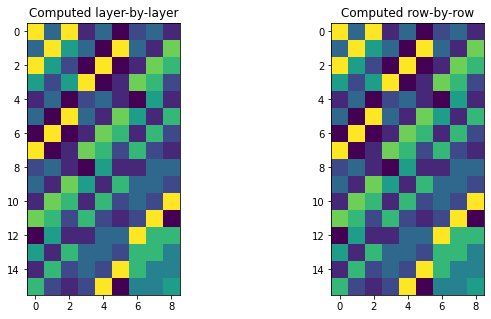

In [22]:
from asdfghjkl.gradient import batch_gradient

def _flatten_after_batch(tensor: torch.Tensor):
    if tensor.ndim == 1:
        return tensor.unsqueeze(-1)
    else:
        return tensor.flatten(start_dim=1)
        
def _get_batch_grad(model):
    batch_grads = list()
    for module in model.modules():
        if hasattr(module, 'op_results'):
            res = module.op_results['batch_grads']
            if 'weight' in res:
                batch_grads.append(_flatten_after_batch(res['weight']))
            if 'bias' in res:
                batch_grads.append(_flatten_after_batch(res['bias']))
            if len(set(res.keys()) - {'weight', 'bias'}) > 0:
                raise ValueError(f'Invalid parameter keys {res.keys()}')
    return torch.cat(batch_grads, dim=1)

'''def batch_gradient(model, loss_fn, inputs, targets):
    with extend(model, OP_BATCH_GRADS):
        model.zero_grad()
        f = model(inputs)
        loss = loss_fn(f, targets)
        loss.backward()
    return f'''
    
def jacobians(x, model, output_size=784):
    """Compute Jacobians \\(\\nabla_\\theta f(x;\\theta)\\) at current parameter \\(\\theta\\)
    using asdfghjkl's gradient per output dimension.
    Parameters
    ----------
    x : torch.Tensor
        input data `(batch, input_shape)` on compatible device with model.
    Returns
    -------
    Js : torch.Tensor
        Jacobians `(batch, parameters, outputs)`
    f : torch.Tensor
        output function `(batch, outputs)`
    """
    Js = list()
    for i in range(output_size):
        for j in range(output_size):
            def loss_fn(outputs, targets):
                return outputs[:, 0, i, j].sum()

            f = batch_gradient(model, loss_fn, x, None).detach()
            Jk = _get_batch_grad(model)

            Js.append(Jk)
    Js = torch.stack(Js, dim=1)

    return Js, f

conv = nnj.Conv2d(1,1,kernel_size=kernel_size,padding=padding,stride=stride,dilation=dilation, bias=None)
Js, _ = jacobians(input, conv, output_size=M)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Computed layer-by-layer')
plt.imshow(full_jacobian_dw.detach().numpy())
plt.subplot(1,2,2)
plt.title('Computed row-by-row')
plt.imshow(Js[0].detach().numpy())